# pyfolio-integration

This example shows how to integrate pinkfish with the pyfolio library.

In [1]:
import datetime

import pyfolio
import matplotlib.pyplot as plt
import pandas as pd
from talib.abstract import *

import pinkfish as pf

# Format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

/usr/local/lib/python3.8/dist-packages/pyfolio-0.9.2-py3.8.egg/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# Set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbol = '^GSPC'
capital = 10000
#start = datetime.datetime(1900, 1, 1)
start = datetime.datetime(*pf.SP500_BEGIN)
end = datetime.datetime.now()

Define Strategy Class - sell in may and go away

In [4]:
class Strategy:

    def __init__(self, symbol, capital, start, end):
        self.symbol = symbol
        self.capital = capital
        self.start = start
        self.end = end
        
        self.ts = None
        self.rlog = None
        self.tlog = None
        self.dbal = None
        self.stats = None

    def _algo(self):
        pf.TradeLog.cash = capital

        for i, row in enumerate(self.ts.itertuples()):

            date = row.Index.to_pydatetime()
            high = row.high; low = row.low; close = row.close; 
            end_flag = pf.is_last_row(self.ts, i)

            # Buy (at the open on first trading day in Nov).
            if self.tlog.shares == 0:
                if row.month == 11 and row.first_dotm:
                    self.tlog.buy(date, row.open)
            # Sell (at the open on first trading day in May).
            else:
                if ((row.month == 5 and row.first_dotm) or end_flag):
                    self.tlog.sell(date, row.open)

            # Record daily balance
            self.dbal.append(date, high, low, close)

    def run(self):
        
        # Fetch and select timeseries.
        self.ts = pf.fetch_timeseries(self.symbol)
        self.ts = pf.select_tradeperiod(self.ts, self.start, self.end,
                                        use_adj=True)
        # Add calendar columns.
        self.ts = pf.calendar(self.ts)
        
        # Finalize timeseries.
        self.ts, self.start = pf.finalize_timeseries(self.ts, self.start)
        
        # Create tlog and dbal objects
        self.tlog = pf.TradeLog(symbol)
        self.dbal = pf.DailyBal()
        
        # Run algorithm, get logs
        self._algo()
        self._get_logs()
        self._get_stats()

    def _get_logs(self):
        self.rlog = self.tlog.get_log_raw()
        self.tlog = self.tlog.get_log()
        self.dbal = self.dbal.get_log(self.tlog)

    def _get_stats(self):
        s.stats = pf.stats(self.ts, self.tlog, self.dbal, self.capital)

Run Strategy

In [5]:
s = Strategy(symbol, capital, start, end)
s.run()

Run Benchmark, Retrieve benchmark logs, and Generate benchmark stats

In [6]:
benchmark = pf.Benchmark(symbol, s.capital, s.start, s.end)
benchmark.run()

Pyfolio Returns Tear Sheet

(create_returns_tear_sheet() seems to be a bit broke in Pyfolio, see: https://github.com/quantopian/pyfolio/issues/520)

In [7]:
# Convert pinkfish data to Empyrical format
returns = s.dbal['close'].pct_change()
#returns.index = returns.index.tz_localize('UTC')
returns.index = returns.index.to_pydatetime()
type(returns.index)

pandas.core.indexes.datetimes.DatetimeIndex

Start date,1957-03-04
End date,2021-04-01
Total months,526
,Backtest
Annual return,8.4%
Cumulative returns,3348.7%
Annual volatility,12.6%
Sharpe ratio,0.70
Calmar ratio,0.22
Stability,0.93
Max drawdown,-37.8%


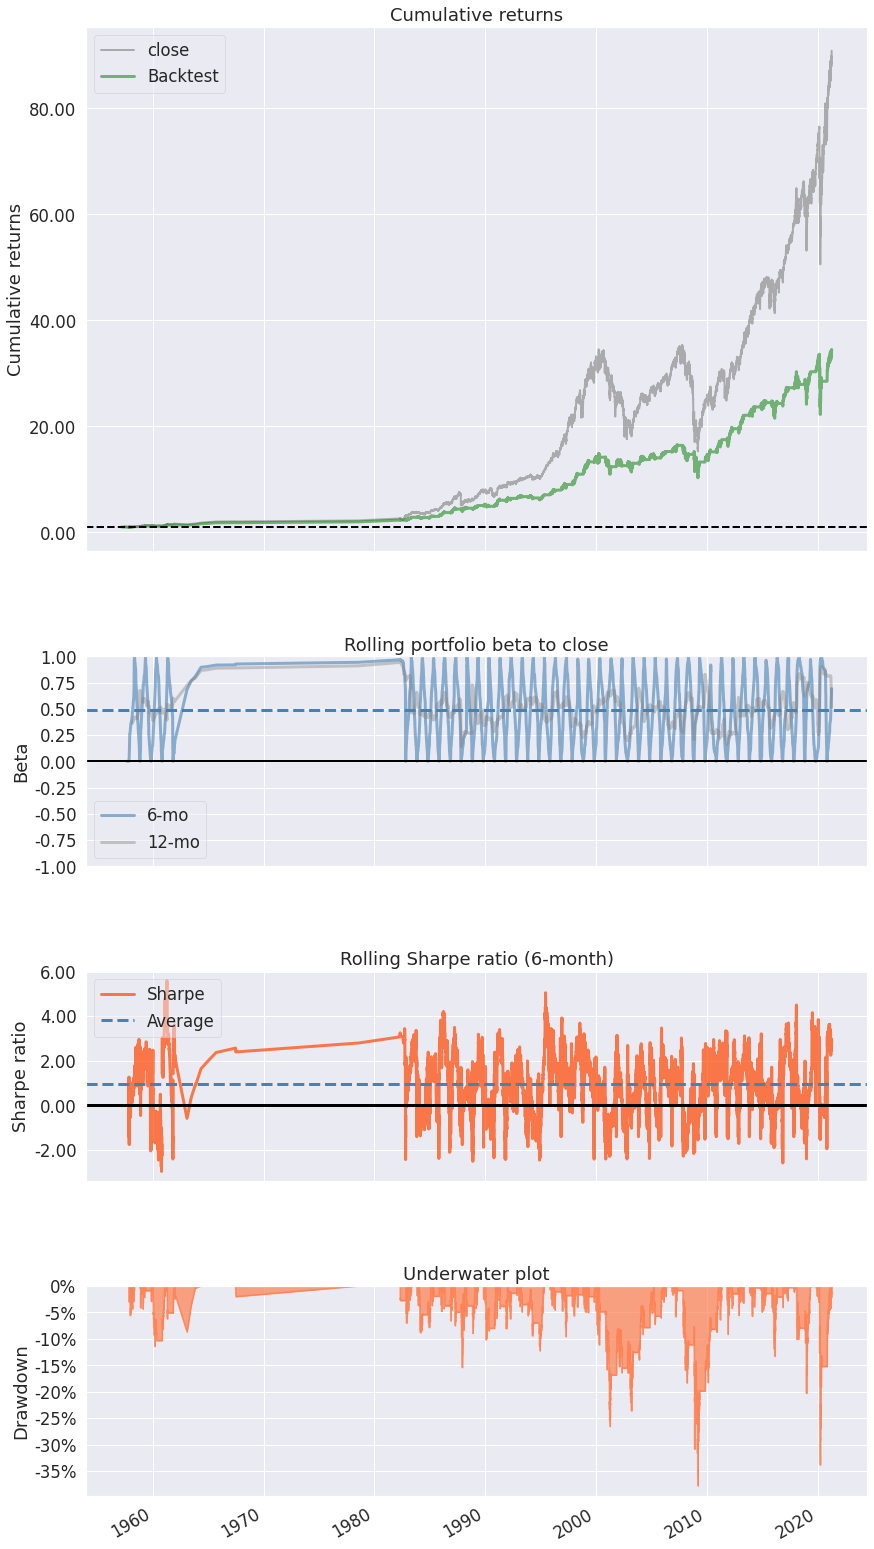

In [8]:
# Filter warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Convert pinkfish data to Empyrical format
returns = s.dbal['close'].pct_change()
returns.index = returns.index.tz_localize('UTC')

benchmark_rets = benchmark.dbal['close'].pct_change()
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC')

live_start_date=None
live_start_date='2010-01-01'

# Uncomment to select the tear sheet you are interested in.

#pyfolio.create_returns_tear_sheet(returns, benchmark_rets=benchmark_rets, live_start_date=live_start_date)
pyfolio.create_simple_tear_sheet(returns, benchmark_rets=benchmark_rets)
#pyfolio.create_interesting_times_tear_sheet(returns, benchmark_rets=benchmark_rets)